In [2]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/numenta'
    '/NAB/master/data/realKnownCause/ambient'
    '_temperature_system_failure.csv')
  
# Exclude datetime column
data_values = data.drop('timestamp',
                        axis=1).values
  
# Convert data to float type
data_values = data_values.astype('float32')
  
# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,
                              columns=data.columns[1:])
  
# Add back datetime column
data_converted.insert(0, 'timestamp',
                      data['timestamp'])

In [4]:
data.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [5]:
data_converted = data_converted.dropna()

In [6]:
data_converted.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880836
1,2013-07-04 01:00:00,71.220230
2,2013-07-04 02:00:00,70.877808
3,2013-07-04 03:00:00,68.959396
4,2013-07-04 04:00:00,69.283554


In [15]:
# Exclude datetime column again
# data_tensor = tf.convert_to_tensor(data_converted.drop('timestamp', axis=1).values, dtype=tf.float32)
# data_tensor = tf.convert_to_tensor(data_converted, dtype=tf.float32)
print(dir(data_tensor))
data_tensor.shape  
print(data_converted.drop('timestamp', axis=1).values)
# print(data_converted[1][0])



ValueError: could not convert string to float: '2013-07-04 00:00:00'

In [35]:
# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
encoding_dim = 10
  
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
  
# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
                batch_size=32, shuffle=True)
  
# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

Epoch 1/50
228/228 [==============================] - 2s 2ms/step - loss: 999.1629
Epoch 2/50
228/228 [==============================] - 0s 1ms/step - loss: 0.6872
Epoch 3/50
228/228 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 4/50
228/228 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5/50
228/228 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 6/50
228/228 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 7/50
228/228 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 8/50
228/228 [==============================] - 0s 942us/step - loss: 0.0010
Epoch 9/50
228/228 [==============================] - 0s 926us/step - loss: 0.0010
Epoch 10/50
228/228 [==============================] - 0s 956us/step - loss: 0.0010
Epoch 11/50
228/228 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 12/50
228/228 [==============================] - 0s 950us/step - loss: 0.0010
Epoch 13/50
228

In [36]:

threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

In [37]:
test = data_converted['value'].values
predictions = anomaly_scores.values
  
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


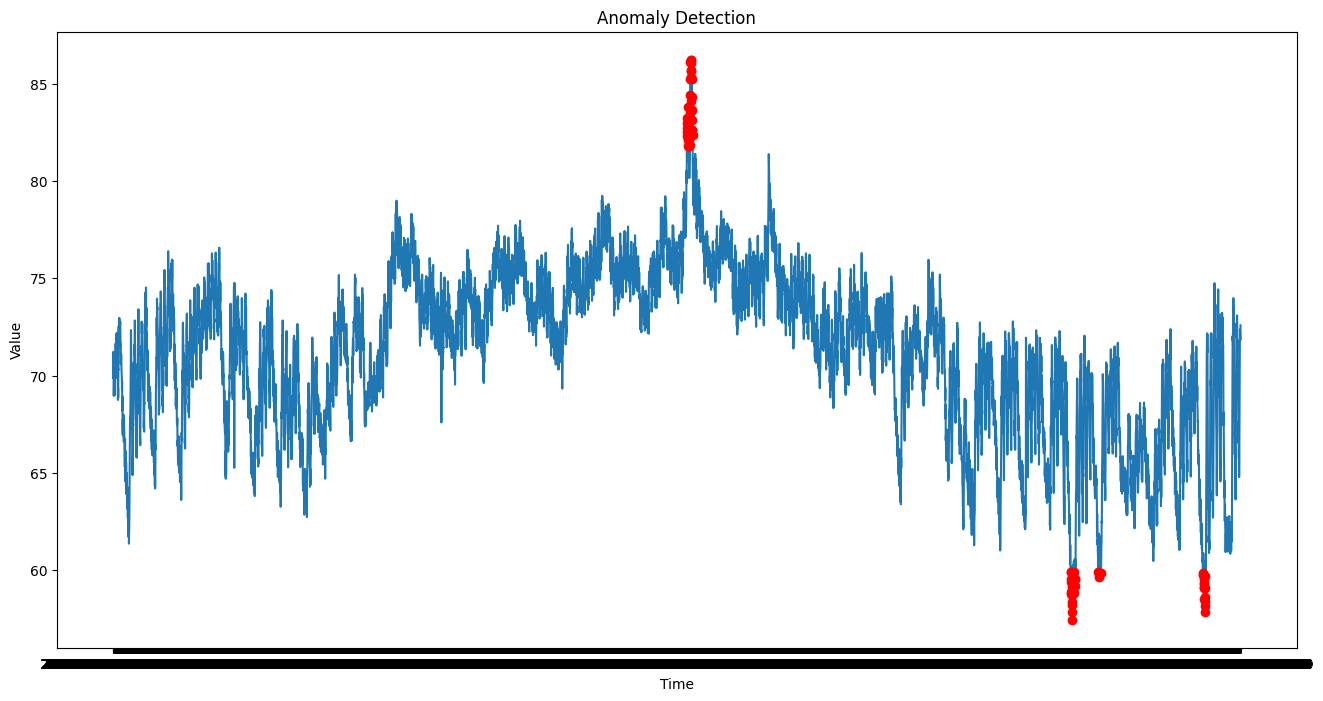

In [38]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
         data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
         data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()